In [1]:
# data tools
import numpy as np
import h5py
import wkw
# skeleton tools
import kimimaro
from cloudvolume import PrecomputedSkeleton
# other tools
import time
import re
import scipy.io as sio
import os
import sys
from tqdm import tqdm
from types import SimpleNamespace
from skimage.transform import rescale, resize, downscale_local_mean
import datetime
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label,find_objects
from scipy import ndimage
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure, iterate_structure
# from scipy.ndimage.morphology import binary_closing, binary_dilation, binary_erosion
# from scipy.ndimage.measurements import label
import time
import multiprocessing
# import cfut
# from concurrent.futures import as_completed
import subprocess
from wkskel import Skeleton
import pandas as pd

/u/vkhare/conda-envs/mpcdf_py37/lib/python3.7/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


In [2]:
wkwPath = "/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_mag2_varun_myelin_column/segmentation/1/"
wkwColor = "/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_mag2_varun_myelin_column/color/1/"
vox_size = [8,8,35]
num_cores= 32
vessel_boxes=np.array([
[78939, 58518, 3631, 5872, 80072, 1324],
[81326, 58526, 4956, 1872, 14072, 300],
[78934, 55973, 4149, 5572, 2544, 1124],
[79336, 53412, 4297, 5572, 2561, 1124],
[79256, 50717, 4343, 4972, 2695, 1124],
[79756, 47471, 4543, 4472, 3072, 1124],
[79756, 44194, 4643, 4472, 3277, 1124],
[79756, 40423, 4943, 4472, 3771, 1124],
[79756, 37363, 5143, 5472, 3060, 1124],
[81256, 33715, 5543, 5472, 3648, 924],
[80939, 138858, 4031, 4572, 7821, 1024],
[80939, 146679, 4431, 4572, 7872, 924],
[80939, 154568, 4731, 4572, 3809, 824],
[80939, 158377, 4931, 4572, 3740, 824],
[80939, 162117, 5131, 4172, 3808, 794],
[80939, 165925, 5431, 3172, 4872, 694],
#new boxes
[113535, 38406, 6653, 2500, 10000, 530],
])

In [5]:
import h5py
hf = h5py.File(file, 'r')

In [6]:
data = hf.get('edges').value

AttributeError: 'NoneType' object has no attribute 'value'

In [7]:
hf.keys()

<KeysViewHDF5 ['agglomerate_to_edges', 'agglomerate_to_edges_offsets', 'agglomerate_to_positions', 'agglomerate_to_segments', 'agglomerate_to_segments_offsets', 'segment_to_agglomerate']>

In [3]:
file = "/tmpscratch/georgwie/artifacts/default/create_agglomerate_view/agglomerate_view__d34deddd98/agglomerate_view_65.hdf5"

In [ ]:
dset = wkw.Dataset.open(wkwPath)
dsetColor = wkw.Dataset.open(wkwColor)
def read_cube(bbox):
    xyz_min = bbox[0:3]
    xyz_diff = bbox[3:]
    cubeData = np.squeeze(dset.read(xyz_min, xyz_diff))
    cubeColor = np.squeeze(dsetColor.read(xyz_min, xyz_diff))
    return cubeData,cubeColor


In [3]:
def get_small_bboxes(bbox, small_bbox_size, overlap=1):
    # > Note : the returned small_bboxes are of size small_bbox_size + overlap
#     assert(np.all(np.mod(bbox[3:], small_bbox_size) == 0))
    num_boxes = np.uint32(bbox[3:] // small_bbox_size)
    small_bboxes = [np.concatenate((
                        bbox[0:3] + np.array([i, j, k]) * small_bbox_size, 
                        small_bbox_size + overlap)) 
                    for i in range(num_boxes[0])
                    for j in range(num_boxes[1])
                    for k in range(num_boxes[2])]
    return small_bboxes

In [4]:
bigBox = np.array([78000,35124,40,44160,144348,7068])
small_bbox_size =np.array([512,512,512])

In [27]:
import pickle
from collections import defaultdict

In [6]:
files = sorted(glob.glob(os.path.join("/u/vkhare/codat/.temp_new", 'skeleton*.pkl')),
               key=os.path.getctime)

list_indices = [int(re.search("_(.*)\.",file.split("/")[-1]).group(1)) for file in files]

In [7]:
num = len(files)

In [8]:
skels = []
for file in tqdm(files[:num//10]):
    skel = pickle.load(open(file,"rb"))[2]
    if skel.vertices.shape[1] == 3:
        skels.append(skel)

100%|██████████| 394/394 [00:18<00:00, 20.96it/s]


In [28]:
holder = defaultdict(dict)

In [32]:
main_index
holder[main_index]["num_comp"]=len(skels[main_index].components())

for indx,comp in enumerate(tqdm(skels[main_index].components())):
    holder[main_index][indx]=[comp.cable_length(),comp.branches(),comp.vertices.shape[0]]

100%|██████████| 342/342 [00:00<00:00, 3226.90it/s]


In [180]:
x =np.array([holder[main_index][i][0] for i in range(holder[main_index]["num_comp"]) if i not in [179]])

In [163]:
z =np.array([holder[main_index][i][2] for i in range(holder[main_index]["num_comp"]) if i not in [179]])

In [177]:
y =[holder[main_index][i][1] for i in range(holder[main_index]["num_comp"]) if i not in [179]]

In [178]:
y = np.array([i.shape[0] for i in y])

In [115]:
list(zip(bin_edges,bin_edges[1:]))[0][0]+list(zip(bin_edges,bin_edges[1:]))[0][1]

2.7815000000000003

In [189]:
x=x/1000

In [190]:
m = (341*np.sum(x*y) - x.sum()*y.sum())/(341*np.sum(x**2)-np.sum(x)**2)

In [191]:
b = (y.sum()-m*x.sum())/341

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Cable length per CC in micrometers')

Text(0, 0.5, 'Number of branches per CC')

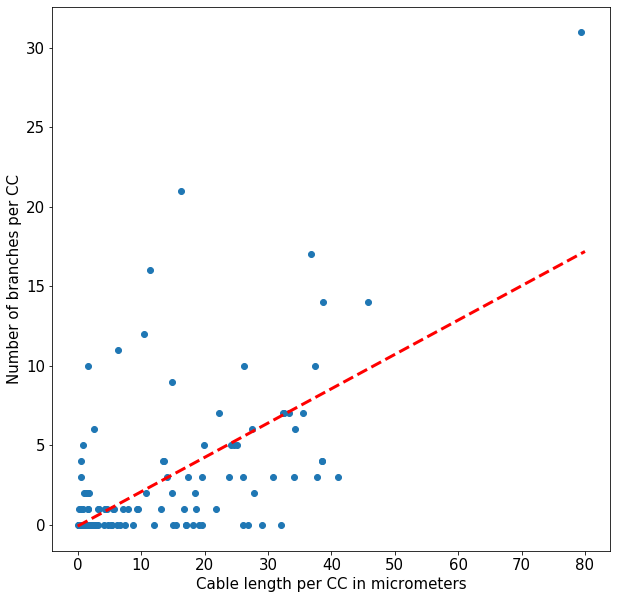

In [192]:
plt.figure(figsize=(10,10))
x_theta = np.linspace(0,80,50)
plt.scatter(x,y)
plt.plot(x_theta,m*x_theta+b,color='red', linestyle='dashed',linewidth=3)
plt.xlabel("Cable length per CC in micrometers")
plt.ylabel("Number of branches per CC")
plt.show()

In [47]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Number of branches per CC')

Text(0, 0.5, 'Number of components')

([<matplotlib.axis.XTick at 0x2b94cf493e10>,
 <a list of 16 Text xticklabel objects>)

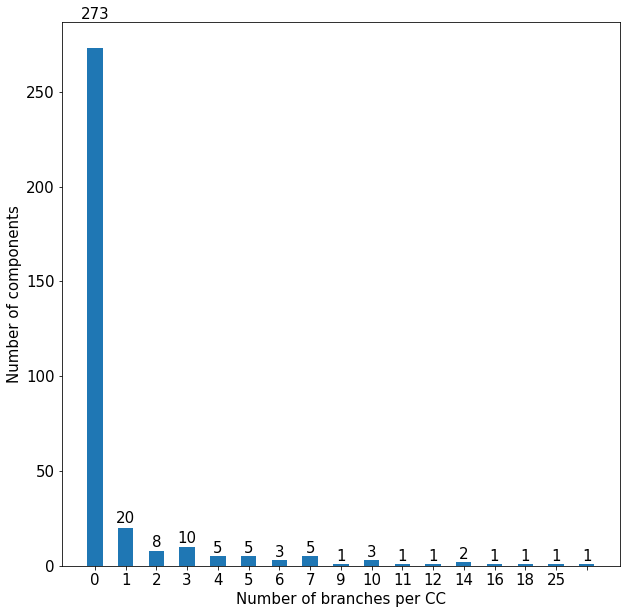

In [138]:
hist, bin_edges = np.histogram(y, bins=10000)
# so we can remove bins with zero entries
non_zero = np.nonzero(hist)
# take only entries where bin is non-zero
hist = hist[non_zero]
bin_edges = bin_edges[non_zero]
# generate labels based on bin edge values (maybe use centers?)
x_ticks = [str(int((edge[0]+edge[1])/2)) for edge in list(zip(bin_edges,bin_edges[1:]))]
indices = np.arange(len(bin_edges))
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
bar = plt.bar(indices, hist, align='center',width=0.5)
plt.xlabel("Number of branches per CC")
plt.ylabel("Number of components")
plt.xticks(indices, x_ticks)
autolabel(bar)
plt.show()

In [69]:
nml_parameters = Skeleton.define_parameters('2018-11-13_scMS109_1to7199_v01_mag2_varun_myelin_column', (8, 8, 35))
# Construct a empty skeleton object by providing the file path
skel_empty2 = Skeleton(parameters=nml_parameters)
id=0
for skel in tqdm(skels[100].components()):
    nodes = (skel.vertices//[8,8,35]).astype(np.int64)
    treeNodes= skel_empty2.define_nodes(position_x=nodes[:,0],
                        position_y=nodes[:,1],
                        position_z=nodes[:,2],
                        id=list(range(id,id+len(nodes))))
    skel_empty2.add_tree(treeNodes,
                        skel.edges+id)
    id=id+len(nodes)
skel_empty2.write_nml("myelin_kimimaro3.nml")

100%|██████████| 342/342 [00:23<00:00, 14.72it/s]
